In [1]:
## Import needed mods
import numpy as np, pandas as pd, os, glob, seaborn as sns
import vcfpy as vcf, hypermutatorqtl as hqtl
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Set paths to phenotype data
pheno_path = '../PHENOTYPE/F1-progeny-info-processed.csv.gz'

## Set path to chromosome length dataframe
chrlen_path = '../DATA/Clens.csv.gz'

## Set paths to genotype dataframes
gt_path = '../GENOTYPE/Bt65xH99_F1_progeny-SNPS.csv.gz'

## Set MAT locus
MAT = hqtl.MAT

## Set parental lables
h99_label = hqtl.h99_label
bt_label =  hqtl.bt_label

## Set kb conversion factor
kb = 1000

## Bring in centromere paths
Centromeres = hqtl.Centromeres

## Load in phenotype data
data = pd.read_csv(pheno_path,index_col=0)

## View head
data.head().T

,30,35,47,10,5
F1 Progeny #,30,35,47,10,5
Mutation rate (qualitative),---,---,---,---,---
Mutation rate (quantitative),0,3.09632e-09,3.37894e-09,5.80508e-09,6.6136e-09
Upper confidence interval,0,2.6642e-10,2.5863e-10,9.7708e-10,1.7808e-09
Lower confidence interval,0,7.93921e-09,8.79736e-09,1.32958e-08,1.34964e-08
Transposition frequency,0,0,100,0,20
Rate,0,0.0309632,0.0337894,0.0580508,0.066136
Uci,0,0.0026642,0.0025863,0.0097708,0.017808
Lci,0,0.0793921,0.0879736,0.132958,0.134964


In [3]:
## Load in genotype data
## Genotypes per site
SNP = pd.read_csv(gt_path,index_col=0)

## Gather columns from dataframe
cols = SNP.columns.tolist()

## Gather samples
samples = cols[:cols.index('Pos')]

## Check work
assert len(samples) == 28, "Missing samples"

## Gather contig names
chrlist = sorted(SNP.Contig.unique())

## Check work
assert len(chrlist) >= 14, "Missing chromosomes in genotype data."

## show shape of df, print a few chromosomes, and print some samples
SNP.shape, chrlist[:3], samples[:3]

((215411, 38), ['Chr_1', 'Chr_10', 'Chr_11'], ['41', '17', '36'])

In [4]:
## Calculate the inter marker interval
imi = np.concatenate([np.abs(np.diff(a[1].Pos)) 
                      for a in SNP.groupby('Contig')])

## take imi < 2 kb
imi_2000 = [i for i in imi if i<2*kb]

## print median imi and percent < 2kb
np.median(imi), len(imi_2000)/len(imi)

(45.0, 0.999470744717893)

In [5]:
## Convert SNP data to float
## Set columns not to be converted
col_not_flot = ['Contig','Alt','Ref','Type']

## Convert each column in SNP
for c in SNP.columns:
    if c not in col_not_flot:
        SNP[c] = SNP[c].apply(float)

## Add parental data
## Set SNP data
SNP['Bt65'] = 1.
SNP['crg1'] = 0.
        
## View head
SNP.head()

,41,17,36,14,12,29,34,26,13,18,...,DPmin,Alt,Ref,Type,Altlen,Qual,NALT,AF,Bt65,crg1
191,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,11.0,T,C,SNV,1.0,4.526492,1.0,0.464286,1.0,0.0
192,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,12.0,T,C,SNV,1.0,4.516699,1.0,0.428571,1.0,0.0
339,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,73.0,G,C,SNV,1.0,4.731814,1.0,0.500000,1.0,0.0
341,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,85.0,T,A,SNV,1.0,4.592010,1.0,0.428571,1.0,0.0
377,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,80.0,G,A,SNV,1.0,4.520617,1.0,0.214286,1.0,0.0


In [6]:
## Load in chromosome length dataframe
clens = pd.read_csv(chrlen_path,index_col=0)

## Calculate the number of SNPs per chromosome
clens['Nsnps'] = [SNP[(SNP.Contig==c)].shape[0] 
                  for c in clens.Contig]

## View head
clens.head()

,Contig,Pos,Cumsum,Midpts,Nsnps
1,Chr_1,2291717,0,1145858.5,25192
2,Chr_2,1618389,2291717,3100911.5,19099
3,Chr_3,1575141,3910106,4697676.5,18159
4,Chr_4,1084216,5485247,6027355.0,12037
5,Chr_5,1821986,6569463,7480456.0,21414


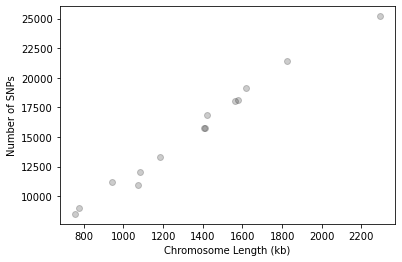

In [7]:
## Plot the number of SNPs as a ftn of chromosome size
plt.plot(clens.Pos.values/kb,clens.Nsnps,'ko',alpha=.2);

## Set y and x-lables
plt.ylabel('Number of SNPs')
plt.xlabel('Chromosome Length (kb)');

In [8]:
## Append parental sample names
if 'Bt65' not in samples:
    samples.append('Bt65')
    samples.append('crg1')
    
## Drop baddies
segs_to_use = [str(s) for s in samples 
               if s not in ['12','14','25','41']]

## print number of segregants
len(segs_to_use)

26

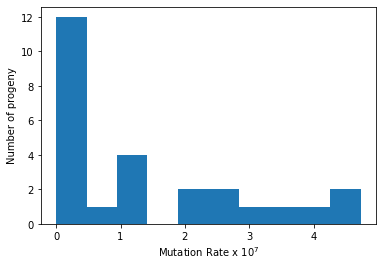

In [9]:
## Gather phenotype data
to_use_data = data.T[segs_to_use].T[['F1 Progeny #','Rate']].copy()#*(10**9)
to_use_data.index =[ str(s) for s in  to_use_data.index]
to_use_data['Rate']=to_use_data['Rate'].apply(float)

## plot histogram of phenotype
plt.hist(to_use_data['Rate'].values);

## add x and ylabel
plt.xlabel('Mutation Rate x 10$^7$')
plt.ylabel('Number of progeny');

In [10]:
## Gather segregants
segs = [s for s in samples if s not in ['Bt65','crg1']]
len(segs)

28

11 12 0.9131366682533448
12 11 0.9131366682533448
23 41 0.7645917173266635
41 23 0.7645917173266635


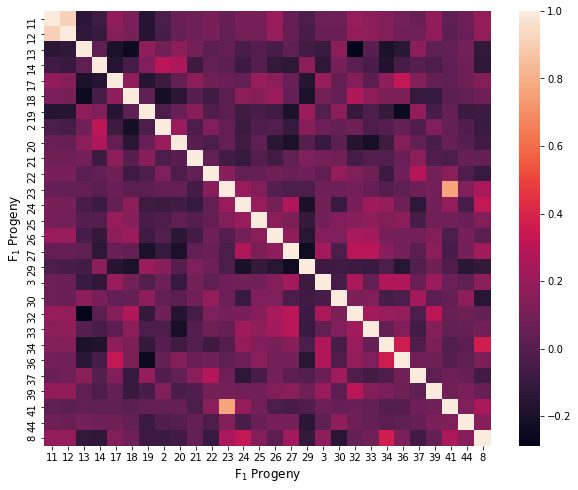

In [11]:
## Plot correlation of genoytpes
## among progeny, identfying clones

## Calculate correlations
corrdf = SNP[sorted(segs)].drop_duplicates().corr()

## Call figure
fig,ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(corrdf);
plt.ylabel('F$_1$ Progeny',fontsize=12)
plt.xlabel('F$_1$ Progeny',fontsize=12);

## print clone corrilation
for s in corrdf.columns:
    for j in corrdf.columns:
        if s != j and corrdf[s][j] > .5:
            print(s,j,corrdf[s][j])

In [12]:
## Check work
assert 'Bt65' in SNP.columns
assert 'crg1' in SNP.columns
assert 'crg1' in segs_to_use
assert 'Bt65' in segs_to_use

In [13]:
## Conduct QTL mapping
## Gather unique loci
test = SNP[segs_to_use].drop_duplicates()

## Check work
assert test.shape[0] <= SNP.shape[0]

## Cunduct QTL mapping
test['Pval'] = test.apply(hqtl.crypto_kruskal,
                args=[to_use_data.T[segs_to_use].T['Rate']],
                axis=1)

## Merge resutls and save
pvaldf = SNP.merge(test)

In [14]:
## Set colors
chrom_colors = hqtl.colors

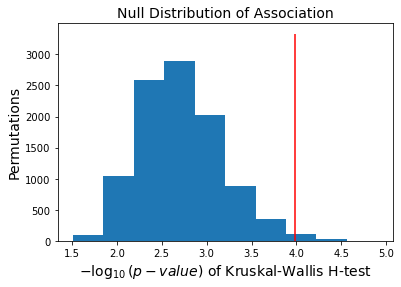

In [15]:
## Conduct permutation tests
## Initilize list
perms = []

## Set number of permutations and save path
kps = 10000
permpath = '../DATA/H99_Hyper_perms.csv.gz'

## Load if they exist
if os.path.exists(permpath):
    perms = pd.read_csv(permpath,index_col=0).T.values[0]

else:
    
    ## Condduct permutations
    ## Gather loci for tests
    test = SNP[segs_to_use].drop_duplicates()
    
    ## Rerun till kps is reached
    while len(perms) < kps:
    
        ## permute segregants
        ran_segs = np.random.permutation(segs_to_use)
        
        ## Cunduct QTL mapping
        test['Pval'] = test[segs_to_use].apply(crypto_kruskal,
                   args=[to_use_data.T[ran_segs].T['Rate'].values],
                   axis=1)
        
        ## Append genome wide max
        perms.append(test.Pval.max())
    
    ## Save perm datarame
    pd.DataFrame(perms).to_csv(permpath)
    
## Gather thresholds and print
thres_95 = np.round(np.percentile(perms,95),2)
thres_99 = np.round(np.percentile(perms,99),2)

## plot null distirbution of association
## plot histogram
plt.hist(perms);

## Add 99 threhsold
plt.vlines(thres_99,0,int(len(perms)/3),color='r');

## Add lables
plt.title('Null Distribution of Association',fontsize=14)
plt.ylabel('Permutations',fontsize=14);
plt.xlabel('$-\log_{10}\,(p-value)$ of Kruskal-Wallis H-test',
           fontsize=14);

In [16]:
## Gather maximum, right chromosome positon 
posmax = clens.Cumsum.tolist()[-1] + clens.Pos.tolist()[-1]

In [17]:
## Slice pvalue dataframe on QTL chormosomes
chr3_ix = pvaldf[(pvaldf.Contig=='Chr_3')].Pval.idxmax()
chr3_gt = pvaldf.T[chr3_ix]
to_use_data['CH3'] = chr3_gt


chr11_ix = pvaldf[(pvaldf.Contig=='Chr_11')].Pval.idxmax()
chr11_gt = pvaldf.T[chr11_ix]
to_use_data['CH11'] = chr11_gt

In [18]:
## Load in statsmdoels
import statsmodels.formula.api as smf

## Conduct linear regression
ch3_res = smf.ols('Rate ~ CH3',data=to_use_data).fit()
ch11_res = smf.ols('Rate ~ CH11',data=to_use_data).fit()

## Gather R2
ch3_rs = np.round(ch3_res.rsquared,2)
ch11_rs = np.round(ch11_res.rsquared,2)

In [19]:
## MAke float
to_use_data['CH3'] = to_use_data['CH3'].apply(float)

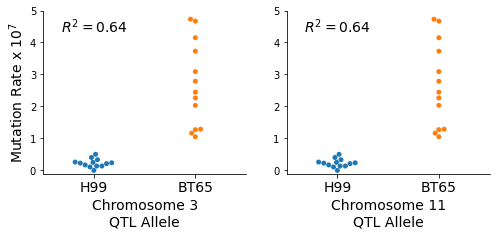

In [20]:
## plot phenotypes by genotypes for 
## Chromosome 3
fig,ax = plt.subplots(1,2,figsize=(8,3))
plt.sca(ax[0])
sns.swarmplot(x='CH3',y='Rate',data=to_use_data);
plt.xlabel('Chromosome 3\nQTL Allele',fontsize=14);
plt.ylabel('Mutation Rate x 10$^7$',fontsize=14)
plt.xticks([0,1],['H99','BT65'],fontsize=14);
plt.ylim(-0.1,5)
[ax[0].spines[s].set_visible(False) for s in ['top','right']]
plt.text(0,4.5,'$R^2 = %s$'%ch3_rs,fontsize=14,va='center',ha='center')

## And chromosome 11
plt.sca(ax[1])
plt.text(0,4.5,'$R^2 = %s$'%ch11_rs,fontsize=14,va='center',ha='center')
sns.swarmplot(x='CH11',y='Rate',data=to_use_data);
plt.ylim(-0.1,5)
plt.ylabel('');plt.xlabel('Chromosome 11\nQTL Allele',fontsize=14);
plt.xticks([0,1],['H99','BT65'],fontsize=14);
[ax[1].spines[s].set_visible(False) for s in ['top','right']];

In [21]:
## Gather chormosome 3 and 11 SNPs
CH3 = SNP[(SNP.Contig=='Chr_3')]
CH11 = SNP[(SNP.Contig=='Chr_11')]

In [22]:
## Conduct boot strapping on chrom 3
## To calculate CI
## Set savepath
ch3_95_savepath = '../DATA/H99_chr3.csv.gz'

## If it dosn't exist, run boot strapping
if not os.path.exists(ch3_95_savepath):
    
    ## CAlcualte 95 CI and save
    ch3l, ch3r = hqtl.qtl_boot(segs_to_use,CH3,to_use_data,'Rate')
    pd.DataFrame([ch3l,ch3r],columns=['Chr_3']).to_csv(ch3_95_savepath)

else:
    
    ## Load dataframe
    ch3_95df = pd.read_csv(ch3_95_savepath,index_col=0)
    ch3l,ch3r = ch3_95df.T.values[0]

## print bounds
ch3l,ch3r

(918548.4125, 1120200.5)

In [23]:
## Conduct boot strapping on chrom 11
## To calculate CI
## Set savepath
ch11_95_savepath = '../DATA/H99_chr11.csv.gz'

## if it dosn't exist, run boot strapping
if not os.path.exists(ch11_95_savepath):
    
    ## Calculte 95 CI and save
    ch11l, ch11r = hqtl.qtl_boot(segs_to_use,CH11,to_use_data,'Rate')
    pd.DataFrame([ch11l,ch11r],columns=['Chr_11']).to_csv(ch11_95_savepath)

else:
    
    ## Load dataframe
    ch11_95df = pd.read_csv(ch11_95_savepath,index_col=0)
    ch11l,ch11r = ch11_95df.T.values[0]
    
## print bounds
ch11l,ch11r

(987379.1125, 1193972.0)

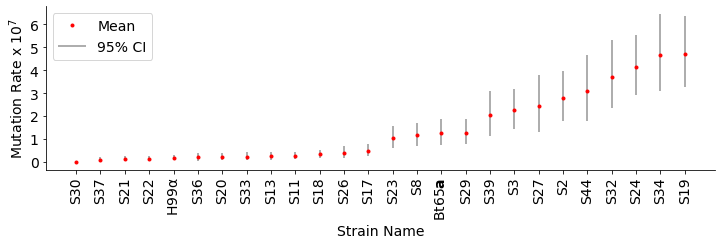

In [24]:
## plot phenotype 
## Gather samples data
to_plot = data.T[segs_to_use].T.sort_values('Rate')

## Call figure
fig, phenoax = plt.subplots(1,1,figsize=(12,3))

## Remove spines
[phenoax.spines[s].set_visible(False) for s in ['top','right']]

## set xpos
xpos = np.arange(to_plot.shape[0])

## plot pphenotypes and 95 CI
plt.plot(xpos,to_plot.Rate,'r.',label='Mean',ms=6);
plt.vlines(xpos,to_plot.Lci,to_plot.Uci,
           'k',alpha=0.42,label='95% CI')

## Add legend and ylable
plt.legend(loc=0,fontsize=14)
plt.ylabel('Mutation Rate x 10$^7$',fontsize=14);

## Add xtick/strian labels
label_plot = []
label_pos = []
for i,s in enumerate(to_plot.index.tolist()):
    
    if s not in ['crg1','Bt65']:
        label_plot.append('S%s'%s)
        label_pos.append(i)
    elif s == 'crg1':
        label_plot.append(h99_label)
    elif s == 'Bt65':
        label_plot.append(bt_label)

## Add xticks, xlables, and yticks
plt.xticks(xpos,label_plot,rotation=90,fontsize=14)
plt.xlabel('Strain Name',fontsize=14)
plt.yticks(np.arange(0,7,1),fontsize=14);

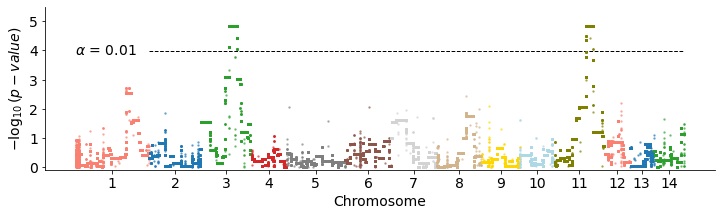

In [25]:
## Manhattan plot
fig,qtlax = plt.subplots(1,1,figsize=(12,3))

[qtlax.spines[s].set_visible(False) for s in ['top','right']];

for i,c in clens.iterrows():
    cumsum = c['Cumsum']
    temp = pvaldf[(pvaldf.Contig==c.Contig)]
    plt.plot(temp.Pos+cumsum,temp.Pval,
             '.',alpha=0.5,
             markersize=3,
             color=chrom_colors[i%len(chrom_colors)]);
    
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.ylim(-0.1,5.5)
plt.yticks(np.arange(6),fontsize=14)

plt.xticks(clens.Midpts.values,clens.index.values,fontsize=14);
plt.xlabel('Chromosome',fontsize=14);

plt.hlines(thres_99,clens.Pos.tolist()[0],
           posmax,linestyle='--',linewidth=1,color='k')

plt.text(clens.Midpts.tolist()[0]*(2.5/3),thres_99,
         s = r'$\alpha$ = 0.01',
         va='center',ha='center',fontsize=14);

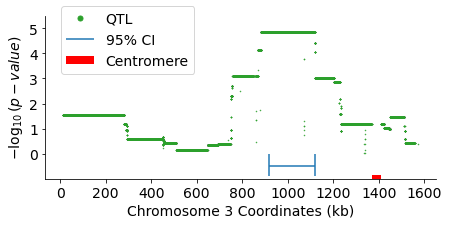

In [26]:
## Chromsome 3 QTL
fig, ch3ax = plt.subplots(1,1,figsize=(7,3))

[ch3ax.spines[s].set_visible(False) for s in ['top','right']];

temp = pvaldf[(pvaldf.Contig=='Chr_3')].copy()
temp.sort_values('Pos',inplace=True)
plt.plot(temp.Pos/1000,temp.Pval,'.',
         color='tab:green',markersize=1,label='QTL');
plt.hlines(-0.5,ch3l/1000,ch3r/1000)
plt.vlines(np.array([ch3l/1000,ch3r/1000]),-.9,0,label='95% CI')
plt.yticks(np.arange(6),fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Chromosome 3 Coordinates (kb)',fontsize=14)
plt.ylim(-1,5.5)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);

plt.hlines(-1,*Centromeres.T[2].values/1000,
           color='red',label='Centromere', linewidth=8)

lgnd = plt.legend(bbox_to_anchor=(.4,1.1),fontsize=14)
lgnd.legendHandles[0]._legmarker.set_markersize(10)
lgnd.legendHandles[2].set_markersize(1);

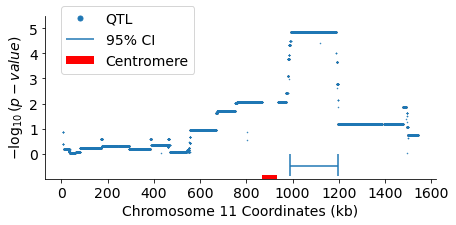

In [27]:
## Chromosome 11 QTL
fig, ch11ax =  plt.subplots(1,1,figsize=(7,3))
[ch11ax.spines[s].set_visible(False) for s in ['top','right']];

temp = pvaldf[(pvaldf.Contig=='Chr_11')].copy()
temp.sort_values('Pos',inplace=True)
plt.plot(temp.Pos/1000,temp.Pval,'.',color='tab:blue',markersize=1,label='QTL');
plt.hlines(-0.5,ch11l/1000,ch11r/1000);
plt.vlines(np.array([ch11l/1000,ch11r/1000]),-.9,0,label='95% CI')
plt.yticks(np.arange(6),fontsize=14);
plt.xlabel('Chromosome 11 Coordinates (kb)',fontsize=14);
plt.xticks(fontsize=14)
plt.ylim(-1,5.5)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=14);
plt.hlines(-1,*Centromeres.T[10].values/1000,
           color='red',label='Centromere',linewidth=8)

lgnd = plt.legend(bbox_to_anchor=(.4,1.1),fontsize=14)
lgnd.legendHandles[0]._legmarker.set_markersize(10)
lgnd.legendHandles[2].set_markersize(1);

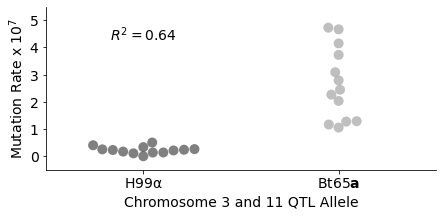

In [28]:
## phenotype by genotype 
fig, ch3pax = plt.subplots(1,1,figsize=(7,3))

[ch3pax.spines[s].set_visible(False) for s in ['top','right']]

sns.swarmplot(x='CH3',y='Rate',data=to_use_data,
              size=10,alpha=0.75,palette='gray')#,palette='viridis');
plt.xlabel('Chromosome 3 and 11 QTL Allele',fontsize=14)
plt.ylabel('Mutation Rate x 10$^7$',fontsize=14)
plt.xticks([0,1],[h99_label,bt_label],fontsize=14)

plt.ylim(-0.5,5.5)
plt.yticks(np.arange(6),fontsize=14)
[ch3pax.spines[s].set_visible(False) for s in ['top','right']]
plt.text(0,4.5,'$R^2 = %s$'%ch3_rs,fontsize=14,
         va='center',ha='center');

In [29]:
## Load in grid spec
from matplotlib.gridspec import GridSpec

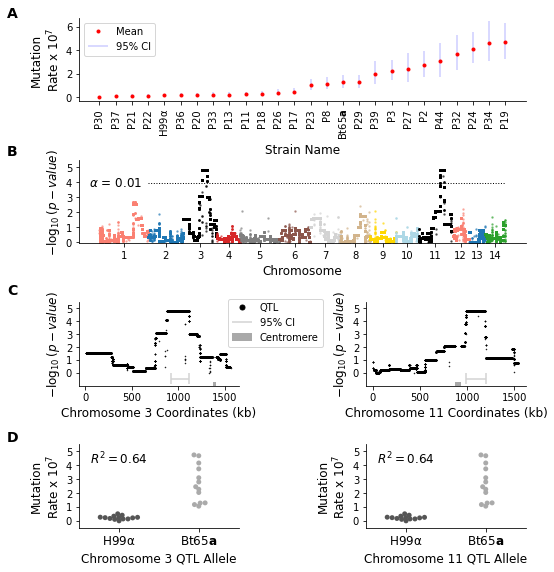

In [30]:
## Call figure and set up grid spec
fig = plt.figure(figsize=(8,12))
gs = GridSpec(5,5,figure=fig)

## set kb conversion
kb = 1000

## Add sub axis
## for phenotypes
phenoax = fig.add_subplot(gs[0,:])

## manhattan plot
qtlax = fig.add_subplot(gs[1,:])

## QTL on chromosomes 3 and 11
ch3ax = fig.add_subplot(gs[2,0:2])
ch11ax = fig.add_subplot(gs[2,3:5])

## Phenotype axis per chromosome
ch3pax = fig.add_subplot(gs[3,0:2])
ch11pax = fig.add_subplot(gs[3,3:5])

## ---------------------------------------------------------------------------------------- ##

## Set axis for phenotype data
plt.sca(phenoax)

## Remove spines
[phenoax.spines[s].set_visible(False) for s in ['top','right']]

## Set x position 
xpos = np.arange(to_plot.shape[0])

## plot phenotype and CI
plt.plot(xpos,to_plot.Rate,'r.',label='Mean');
plt.vlines(xpos,to_plot.Lci,to_plot.Uci,
           'blue',alpha=0.2,label='95% CI')

## Add legend and y-labels
plt.legend(loc=0)
plt.ylabel('Mutation\nRate x 10$^7$',fontsize=12);

## Relable x-axis
label_plot = []
label_pos = []

## Iterate thru samples
for i,s in enumerate(to_plot.index.tolist()):
    
    ## Progeny genotypes
    if s not in ['crg1','Bt65']:
        label_plot.append('P%s'%s)
        label_pos.append(i)
    
    ## H99 parnets
    elif s == 'crg1':
        label_plot.append(h99_label)
        
    ## Bt65 label
    elif s == 'Bt65':
        label_plot.append(bt_label)
        
## Set xticks and xlabel
plt.xticks(xpos,label_plot,rotation=90)
plt.xlabel('Strain Name',fontsize=12)

## ----------------------------------------------------------------------------------------- ##

## Set manhattan axis and remove axis
plt.sca(qtlax)
[qtlax.spines[s].set_visible(False) for s in ['top','right']];

## Iterate thru chromosomes
for i,c in clens.iterrows():
    
    ## slice datframes
    cumsum = c['Cumsum']
    temp = pvaldf[(pvaldf.Contig==c.Contig)]
    
    ## plot QTL
    plt.plot(temp.Pos+cumsum,temp.Pval,
             '.',alpha=0.5,
             markersize=3, 
             color='k' if i in [3,11] else chrom_colors[i%len(chrom_colors)]);

## Set ylabel, limit, and y-ticks
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);
plt.ylim(-0.1,5.5)
plt.yticks(np.arange(6))

## Set xticks and xlables
plt.xticks(clens.Midpts.values,clens.index.values);
plt.xlabel('Chromosome',fontsize=12);

## Plot QTL threshold
plt.hlines(thres_99,clens.Pos.tolist()[0],
           posmax,linestyle=':',linewidth=1,color='k')

## Add label to threshold
plt.text(clens.Midpts.tolist()[0]*(2/3),thres_99,
         s = r'$\alpha$ = 0.01',
         va='center',ha='center',fontsize=12)

## ----------------------------------------------------------------------------------------- ##

## Set chromosome QTL 3 axis and remove spines
plt.sca(ch3ax)
[ch3ax.spines[s].set_visible(False) for s in ['top','right']];

## Gather temp chromosome dataframe sort by position
temp = pvaldf[(pvaldf.Contig=='Chr_3')].copy()
temp.sort_values('Pos',inplace=True)

## plot QTL
plt.plot(temp.Pos/kb,temp.Pval,'.',
         color='k',
         markersize=1,label='QTL');

## plot CI
plt.hlines(-0.5,ch3l/kb,ch3r/kb,color='lightgrey');
plt.vlines(np.array([ch3l/kb,ch3r/kb]),-.9,0,
           label='95% CI',color='lightgrey')

## Set ytikcs, xlable, ylimit, and ylabels
plt.yticks(np.arange(6));
plt.xlabel('Chromosome 3 Coordinates (kb)',fontsize=12)
plt.ylim(-1,5.5)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);

## Add centromere
plt.hlines(-1,*Centromeres.T[2].values/kb,
           color='darkgrey',label='Centromere',linewidth=8)

## Add legend
lgnd = plt.legend(bbox_to_anchor=(.9,1.1))
lgnd.legendHandles[0]._legmarker.set_markersize(10)
lgnd.legendHandles[2].set_markersize(1)

## ------------------------------------------------------------------------------------------- ##

## Set chromosome QTL 11 axis and remove spines
plt.sca(ch11ax)
[ch11ax.spines[s].set_visible(False) for s in ['top','right']];

## Slice dataframe sort by pos
temp = pvaldf[(pvaldf.Contig=='Chr_11')].copy()
temp.sort_values('Pos',inplace=True)

## plot QTL
plt.plot(temp.Pos/kb,temp.Pval,'.',
         color='k',markersize=1);

## Add CI
plt.hlines(-0.5,ch11l/kb,ch11r/kb,color='lightgrey');
plt.vlines(np.array([ch11l/kb,ch11r/kb]),-.9,0,color='lightgrey')

## Set yticks, xlabel, ylim, ylabel
plt.yticks(np.arange(6));
plt.xlabel('Chromosome 11 Coordinates (kb)',fontsize=12);
plt.ylim(-1,5.5)
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=12);

## plot centromere
plt.hlines(-1,*Centromeres.T[10].values/kb,
           color='darkgrey',label='Centromere',linewidth=8)

## ------------------------------------------------------------------------------------------ ##

## set axis for chromosome 3 phenotype data and 
## remove spines
plt.sca(ch3pax)
[ch3pax.spines[s].set_visible(False) for s in ['top','right']];

## Plot swamplot for chromosome 3 genotype x phenotype
sns.swarmplot(x='CH3',y='Rate',data=to_use_data,palette='gray');

## Set xlabel and xticks
plt.xlabel('Chromosome 3 QTL Allele',fontsize=12);
plt.xticks([0,1],[h99_label,bt_label],fontsize=12);

## Set ylimits, ylabel, and yticks
plt.ylim(-0.5,5.5)
plt.ylabel('Mutation\nRate x 10$^7$',fontsize=12)
plt.yticks(np.arange(6))

#[ch3pax.spines[s].set_visible(False) for s in ['top','right']]
## annotate R2
plt.text(0,4.5,'$R^2 = %s$'%ch3_rs,fontsize=12,va='center',ha='center')

## ------------------------------------------------------------------------------------------ ##

## Set axis for chromosome 11 swarm plot
## and remove spines
plt.sca(ch11pax)
[ch11pax.spines[s].set_visible(False) 
 for s in ['top','right']];

## annotate plot
plt.text(0,4.5,'$R^2 = %s$'%ch11_rs,
         fontsize=12,va='center',ha='center')

## plot swarm
sns.swarmplot(x='CH11',y='Rate',
              data=to_use_data,palette='gray')

## Set ylim, yticks, and ylabel
plt.ylim(-0.5,5.5)
plt.yticks(np.arange(6))
plt.ylabel('Mutation\nRate x 10$^7$',fontsize=12)

## Set x-label and xticks
plt.xlabel('Chromosome 11 QTL Allele',fontsize=12);
plt.xticks([0,1],[h99_label,bt_label],fontsize=12);

## ----------------------------------------------------- ##

## Adjust suplots
plt.subplots_adjust(hspace=0.7,wspace=0.5);

## Add figure section lables
fig.text(0,0.88,'A',fontweight='bold',fontsize=14)
fig.text(0,0.72,'B',fontweight='bold',fontsize=14)
fig.text(0,0.56,'C',fontweight='bold',fontsize=14)
fig.text(0,0.39,'D',fontweight='bold',fontsize=14)

## Set save path
savepath = '../FIGURES/Figure_4_Hypermutator_Phenotypes_and_QTL.pdf'

## Save figure
plt.savefig(savepath,dpi=300,bbox_inches='tight');

108 and 85 genes (respectively) and I was unable to analyze 26 and 8 of them (respectively)

In [32]:
## SAve pvalue dataframe
pvaldf.to_csv('../DATA/Bt65xH99_SNP_QTL.csv.gz')